In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

2


0.017032731123124076 inf


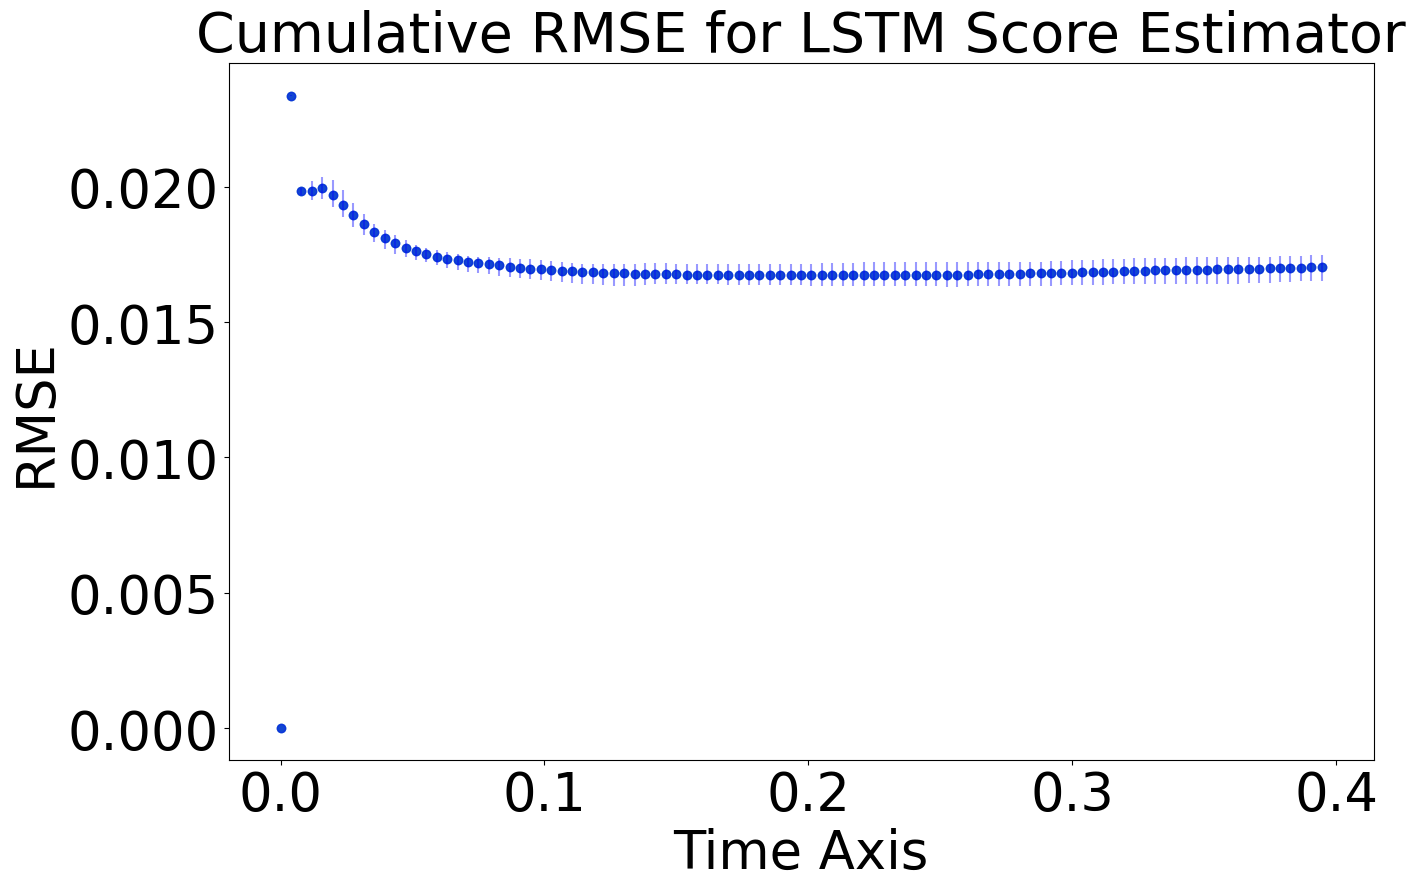

Final time cumulative RMSE local-time error 0.017032731123124076 with final IQR (0.016523634081441654, 0.01748496179494255) at Nepoch 60

0.015234340560011286 0.017032731123124076


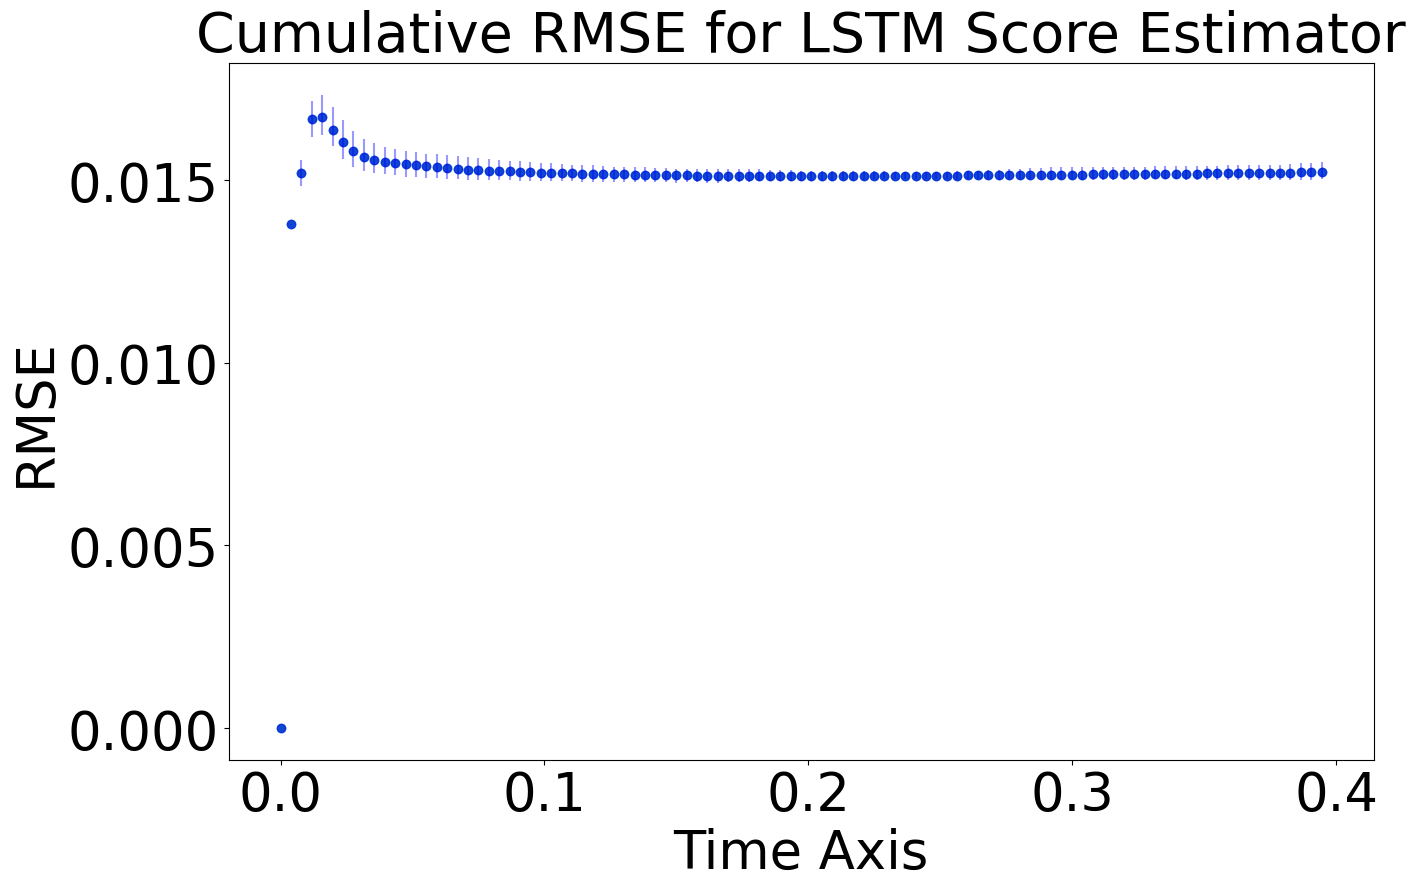

Final time cumulative RMSE local-time error 0.015234340560011286 with final IQR (0.015024274366649203, 0.015493735873859495) at Nepoch 100

0.02032478798572878 0.015234340560011286
0.003612501799108185 0.015234340560011286


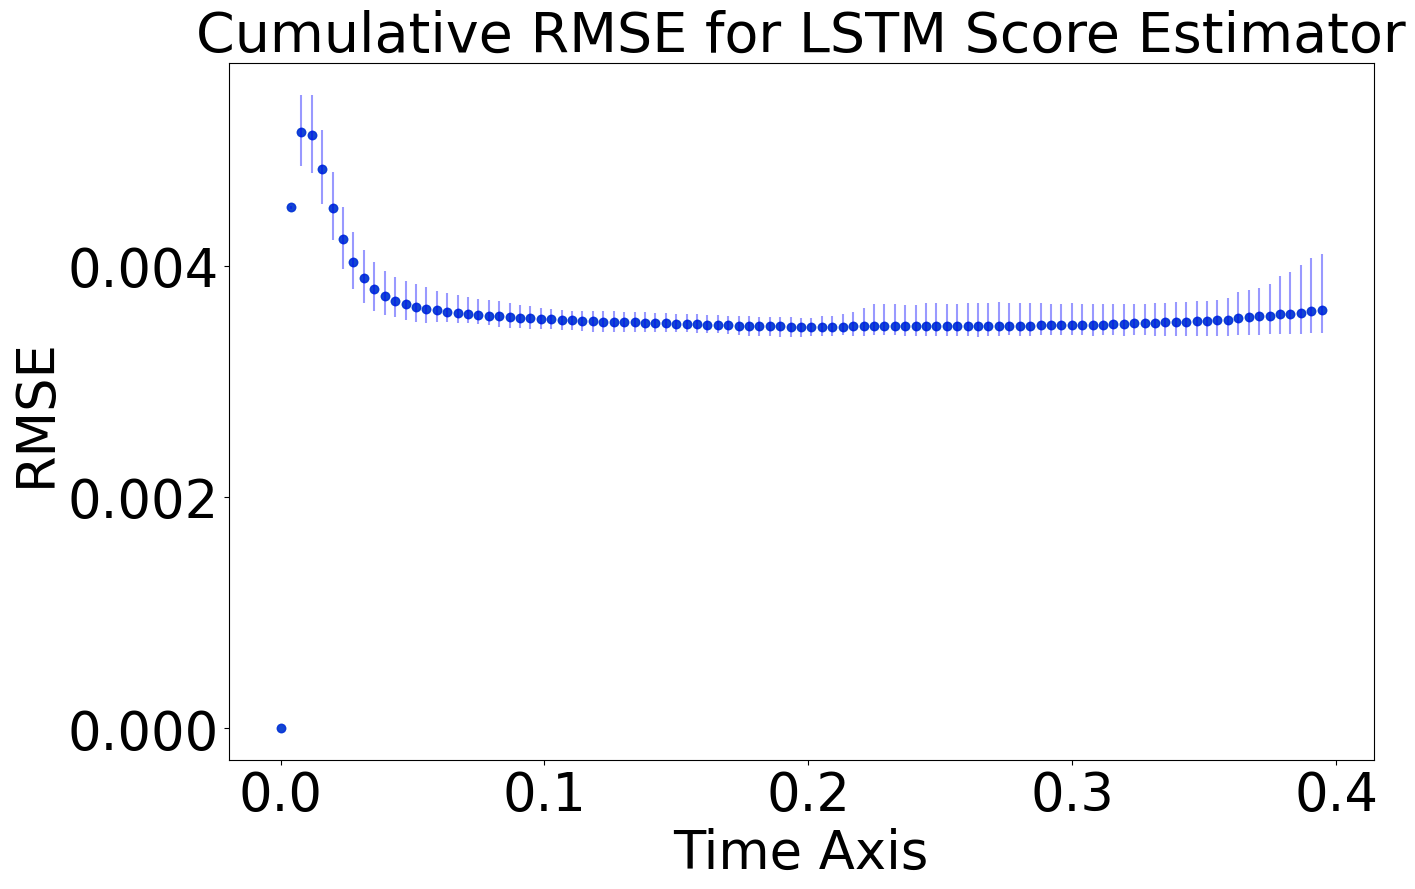

Final time cumulative RMSE local-time error 0.003612501799108185 with final IQR (0.0034204176970458623, 0.004103869455945821) at Nepoch 300

0.006749478167055736 0.003612501799108185
0.007323482648785321 0.003612501799108185
0.005943534062111396 0.003612501799108185
0.006542203780852669 0.003612501799108185
0.005805899341193245 0.003612501799108185
0.006930972350661599 0.003612501799108185
0.01009191297638242 0.003612501799108185
0.010219069819303027 0.003612501799108185


In [6]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        if "_ST_" in config.scoreNet_trained_path:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fBiPot_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fBiPot_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fBiPot_OOSDriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {curr_rmse} with final IQR {total_local_errors_minq[-1], total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue